<a href="https://colab.research.google.com/github/ThaminduSulakshana/RNN-Based-Molecule-generation/blob/main/RNN_Based_Molecule_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate molecular formulas for de novo-drug discovery.

## Import and dependancies

In [ ]:
!pip install rdkit-pypi

In [ ]:
import yaml
import pandas as pd
import numpy as np
import random
from rdkit.Chem import QED,MolFromSmiles
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional,Input
from rdkit.Chem import MolToSmiles
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdkit.Chem.Draw import MolToImage

## Saving config

In [ ]:
def save_config(dictionnaire, chemin_fichier="config.yml"):
    with open(chemin_fichier, "w") as fichier:
        yaml.dump(dictionnaire, fichier)
    print("Fichier YAML sauvegardé avec succès.")


def read_yaml(chemin_fichier):
    if os.path.exists(chemin_fichier):
        with open(chemin_fichier, "r") as fichier:
            contenu = yaml.safe_load(fichier)
    else:
        contenu = {}
    return contenu

In [ ]:
config = {}

## Loading the data

In [ ]:
! [ -e 250k_smiles.csv ] || wget https://raw.githubusercontent.com/joeymach/Leveraging-VAE-to-generate-molecules/master/250k_smiles.csv

In [ ]:
df = pd.read_csv(filepath_or_buffer="250k_smiles.csv", nrows=1000)

Compute the biggest smile molecule size

In [ ]:
len(max(df["smiles"], key=lambda s: len(s)))

106

In [ ]:
def unic_characters(string :str):
    return np.unique(list(string))

Testons cette fonction:

In [ ]:
unic_characters("AAAABAAACCCDDDEE")

array(['A', 'B', 'C', 'D', 'E'], dtype='<U1')

Concatenate all smile string of the pandas dataframe and use **unic_characters** to get the unic_characters

In [ ]:
unic_chars = unic_characters(df["smiles"].sum())

In [ ]:
def map_char_to_int(unic_chars):
    dictionnary = {}
    for i, char in enumerate(unic_chars):
        dictionnary[char] = i
    return dictionnary

In [ ]:
map_char_to_int(unic_chars)

{'\n': 0,
 '#': 1,
 '(': 2,
 ')': 3,
 '+': 4,
 '-': 5,
 '/': 6,
 '1': 7,
 '2': 8,
 '3': 9,
 '4': 10,
 '5': 11,
 '6': 12,
 '7': 13,
 '=': 14,
 '@': 15,
 'B': 16,
 'C': 17,
 'F': 18,
 'H': 19,
 'I': 20,
 'N': 21,
 'O': 22,
 'S': 23,
 '[': 24,
 '\\': 25,
 ']': 26,
 'c': 27,
 'l': 28,
 'n': 29,
 'o': 30,
 'r': 31,
 's': 32}

In [ ]:
def map_int_to_char(unic_chars):
    dictionnary = {}
    for i, char in enumerate(unic_chars):
        dictionnary[i] = char
    return dictionnary

In [ ]:
class MolEncoder:
    def __init__(self, unic_characters: np.array = None, string_set =None):
        if unic_characters is not None:
            self.unic_chars = unic_characters
            self.char_to_int = map_char_to_int(unic_chars)
            self.int_to_char = map_int_to_char(unic_chars)
            self.voc_len = len(unic_chars)
            return
        int_val = 0
        self.char_to_int = {}
        self.int_to_char = {}
        for chaine in tqdm(string_set):
            for char in chaine:
                if char not in self.char_to_int.keys():
                    self.char_to_int[char] = int_val
                    self.int_to_char[int_val] = char
                    int_val += 1
        self.unic_chars = [key for key in self.char_to_int.keys()]
        self.voc_len = len(self.unic_chars)

    def get_char(self, int_val):
        return self.int_to_char[int_val]

    def get_int(self, char):
        return self.char_to_int[char]

    def encode_mol(self, smiles):
        return np.array([self.char_to_int[char] for char in smiles])

    def get_one_hot(self, int_value: int = None, char: chr = None):
        if int_value is None:
            int_value = self.get_int(char)
        elif char is None:
            char = self.get_char(int_value)
        one_hot = np.zeros(self.voc_len)
        one_hot[int_value] = 1
        return one_hot

    def decode_mol(self, encoded_mol):
        return "".join([self.int_to_char[int] for int in encoded_mol])

In [ ]:
unic_chars = unic_characters(df["smiles"].sum())
mol_encoder = MolEncoder(unic_chars)
print(mol_encoder.get_char(17))
print(mol_encoder.get_int("C"))
print(mol_encoder.get_one_hot(17))
assert np.all(mol_encoder.get_one_hot(17) == mol_encoder.get_one_hot(char="C"))

C
17
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
mol_smile = df["smiles"][random.randint(0, len(df))]
ecnoded = mol_encoder.encode_mol(mol_smile)
assert mol_encoder.decode_mol(ecnoded) == mol_smile

Code a function **build_X_and_y(string, i_char, seq_lenght)** which takes a string, a **seq_length** number and a position.


It should create X by by getting all character between i and i + seq_length
and create y by getting the character following the X sequence
it returns X and y

In [ ]:
def build_X_and_y(
    string: str,
    i_char: int,
    seq_length: int,
    mol_encoder: MolEncoder = None,
    one_hot: bool = False,
):
    encode_method = (
        mol_encoder.get_int
        if not one_hot
        else lambda x: mol_encoder.get_one_hot(char=x)
    )
    X = [encode_method(char) for char in string[i_char : i_char + seq_length]]
    y = encode_method(string[i_char + seq_length])
    return X, y

Test function on the following string "OCC(C)(C)c1ccc" with seq_length = 4 and i = [1, 2, 3]

In [ ]:
tested_string = "CC(C)(C)c1ccc"
seq_len = 3
for i_char in range(1, 4):
    X, y = build_X_and_y(
        tested_string, i_char=i_char, seq_length=seq_len, mol_encoder=mol_encoder
    )
    print(
        f"l'encodage de {tested_string[i_char:i_char+seq_len]} est {X} et le caractère suivant est {y}"
    )

l'encodage de C(C est [17, 2, 17] et le caractère suivant est 3
l'encodage de (C) est [2, 17, 3] et le caractère suivant est 2
l'encodage de C)( est [17, 3, 2] et le caractère suivant est 17


By using build_X_and_y and map_char_to_int build a list nameed X_train and a list named y_train

In [ ]:
def generate_ds(seq_len = 10, mol_encoder = None):
    X_train, y_train = [], []
    for mol in df["smiles"]:
        for i in range(len(mol) - seq_len):
            X, y = build_X_and_y(mol, i_char=i, seq_length=seq_len, mol_encoder=mol_encoder)
            X_train.append(X)
            y_train.append(y)
    return np.array(X_train),np.array(y_train)

Create numpy arrays from the lists

In [ ]:
X_train ,y_train = generate_ds(10,mol_encoder)

In [ ]:
X_train.shape, y_train.shape

((35242, 10), (35242,))

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [ ]:
X_train.shape, y_train.shape

((35242, 10, 1), (35242,))

In [ ]:
X_train = X_train / mol_encoder.voc_len

In [ ]:
assert np.all(X_train < 1)

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation="softmax"))

Compile the model with the appropriate loss function and the adam optimizer

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 10, 128)           66560     
                                                                 
 dropout_24 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_25 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________


Train the model on 20 epochs and 10 examples (yeah you read correctly) and check that the model overfits !

In [ ]:
# Convert X_train to tensor
n_samples = 10
X_train_tensor = tf.convert_to_tensor(X_train[:n_samples])
y_train_tensor = tf.convert_to_tensor(y_train[:n_samples])

In [ ]:
n_epochs = 20
config['epochs'] = n_epochs
history = model.fit(X_train_tensor, y_train_tensor, epochs=n_epochs)

Epoch 1/20
1/1 [==============================] - 5s 5s/step - loss: nan - accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 13ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 13ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 13ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 12ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 12ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 11ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 0s 12ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 0s 12ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 11/20
1/1 [====

If it does not overfit try to fix data prep and model architecture so it does

In [ ]:
seq_len = 20
config["seq_len"] = seq_len
def generate_one_hot_ds(seq_len,mol_encoder,smiles_set):
    X_train, y_train = [],[]
    for mol in tqdm(smiles_set):
        for i in range(len(mol) - seq_len):
            X, y = build_X_and_y(
                mol, i_char=i, seq_length=seq_len, mol_encoder=mol_encoder, one_hot=True
            )
            X_train.append(X)
            y_train.append(y)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    assert X_train.shape[1:] == (seq_len, mol_encoder.voc_len)
    assert y_train.shape[1] == (mol_encoder.voc_len)
    return X_train,y_train


In [ ]:
def build_one_hot_model(seq_len, voc_len):
    model = Sequential(
        [
            Input(shape=(seq_len, voc_len)),
            LSTM(128,return_sequences=True),
            Dropout(0.2),
            LSTM(128),
            Dropout(0.2),
            Dense(voc_len, activation="softmax"),
        ]
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # tf.keras.optimizers.RMSprop(learning_rate=0.01)
    model.compile(
        loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )
    return model

In [ ]:
X_train, y_train = generate_one_hot_ds(seq_len,mol_encoder,df['smiles'])
X_train_tensor = tf.convert_to_tensor(X_train)
y_train_tensor = tf.convert_to_tensor(y_train)

100%|██████████| 1000/1000 [00:01<00:00, 956.22it/s]


In [ ]:
model = build_one_hot_model(seq_len,mol_encoder.voc_len)
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 20, 128)           82944     
                                                                 
 dropout_26 (Dropout)        (None, 20, 128)           0         
                                                                 
 lstm_27 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_27 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 33)                4257      
                                                                 
Total params: 218,785
Trainable params: 218,785
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def save_history(model, history,hist_file_name):
    history_df = pd.DataFrame(history.history)
    hist_file_name = f"{model.name}_history.csv"
    history_df.to_csv(os.path.join(hist_file_name))

Create a function **make_prediction(seed_start)** which takes a starting string sequence and uses it to generate a molecule


In [ ]:
def make_prediction(seed_start: str,model,mol_encoder,seq_len):
    seed = seed_start
    for i in range(50):
        X = np.zeros((1, seq_len, mol_encoder.voc_len))
        for j, char in enumerate(seed[-seq_len:]):
            X[0, j, mol_encoder.get_int(char)] = 1
        y = model.predict(X,verbose=0)
        next_char = mol_encoder.get_char(np.argmax(y))
        seed += next_char
        if next_char == "\n":
            break
    return seed

def make_prediction_alternate(seed_start: str,model=None,mol_encoder=None,seq_len=0):
    seed = ""
    seed_start
    for i in range(50):
        X = np.zeros((1, seq_len, mol_encoder.voc_len))
        for j, char in enumerate(seed_start):
            X[0, j, mol_encoder.get_int(char)] = 1
        y = model.predict(X,verbose=0)
        next_char = mol_encoder.get_char(np.argmax(y))
        seed_start = seed_start[1:] + next_char
        seed += next_char
        if next_char == "\n":
            break
    return seed

In [ ]:
def plot_history(history=None, file_name=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if file_name is None:
        history_df = pd.DataFrame(history.history)
    else:
        history_df = pd.read_csv(file_name)

    #
    history_df[["val_accuracy", "accuracy"]].plot(ax=ax1)
    ax1.set_title('Précision')
    ax1.set_xlabel('Époque')
    ax1.set_ylabel('Précision')
    ax1.legend(["Validation", "Entraînement"])


    history_df[["loss", "val_loss"]].plot(ax=ax2)
    ax2.set_title('Perte')
    ax2.set_xlabel('Époque')
    ax2.set_ylabel('Perte')
    ax2.legend(["Entraînement", "Validation"])

    plt.suptitle("Historique d'entraînement")
    plt.show()

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience:int=0, model_file:str="model.h5"):
        self.patience = patience
        self.counter = 0
        self.min_val_loss = float("inf")
        self.model_file_path = model_file
        # self.model.save(os.path.join(self.model_file_path))

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get("val_loss")

        if val_loss < self.min_val_loss:
            self.min_val_loss = val_loss
            print(f"\nNew Mininimum for validation loss: {self.min_val_loss}")
            print(f"Saving {self.model_file_path}, {epoch = }")
            self.model.save(os.path.join(self.model_file_path))

Epoch 1/20
630/632 [============================>.] - ETA: 0s - loss: 2.2157 - accuracy: 0.3597
New Mininimum for validation loss: 1.6510652303695679
Saving one_hot_model_1.h5, epoch = 0
632/632 [==============================] - 11s 11ms/step - loss: 2.2146 - accuracy: 0.3600 - val_loss: 1.6511 - val_accuracy: 0.4805
Epoch 2/20
632/632 [==============================] - ETA: 0s - loss: 1.5083 - accuracy: 0.5352
New Mininimum for validation loss: 1.3472808599472046
Saving one_hot_model_1.h5, epoch = 1
632/632 [==============================] - 5s 8ms/step - loss: 1.5083 - accuracy: 0.5352 - val_loss: 1.3473 - val_accuracy: 0.5742
Epoch 3/20
631/632 [============================>.] - ETA: 0s - loss: 1.3194 - accuracy: 0.5792
New Mininimum for validation loss: 1.2457236051559448
Saving one_hot_model_1.h5, epoch = 2
632/632 [==============================] - 6s 9ms/step - loss: 1.3193 - accuracy: 0.5792 - val_loss: 1.2457 - val_accuracy: 0.5985
Epoch 4/20
628/632 [========================

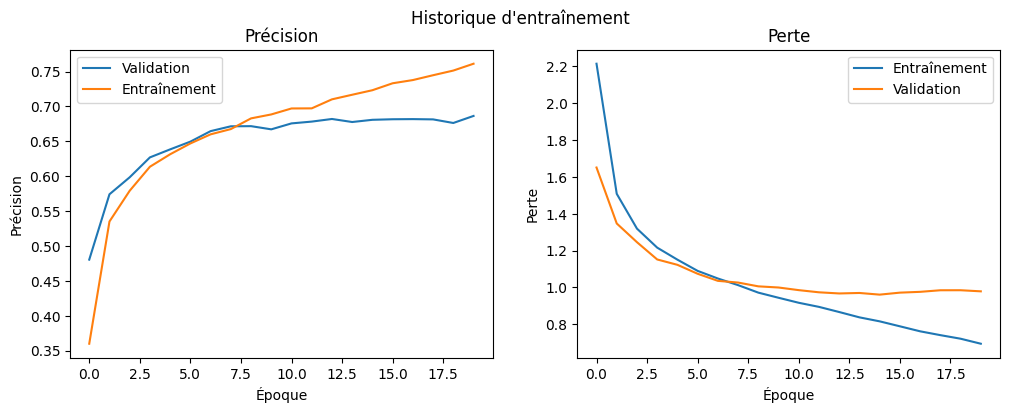

In [ ]:
config["callback_param"] = dict(patience=2,model_file="one_hot_model_1.h5")
callbacks = [MyCustomCallback(**config["callback_param"])]
model = build_one_hot_model(seq_len,mol_encoder.voc_len)
history = model.fit(X_train_tensor, y_train_tensor, epochs=20,validation_split=0.2,callbacks=callbacks)
save_history(model,history,"history_1.csv")
plot_history(history)

generate a molecule of your overfitted model

In [ ]:
seed_start = random.choice(df['smiles'])[:seq_len]
make_prediction(seed_start,model,mol_encoder,seq_len)

'C[C@@H]1CCC[C@](O)(c1ccc(Cl)cc1)C(=O)N1CCOCC1\n'

In [ ]:
full_df = pd.read_csv(filepath_or_buffer="250k_smiles.csv",nrows=10000)

In [ ]:
mol_encoder_2 = MolEncoder(string_set=full_df['smiles'])

100%|██████████| 10000/10000 [00:00<00:00, 124825.28it/s]


In [ ]:
X_train, y_train = generate_one_hot_ds(seq_len,mol_encoder_2,full_df['smiles'])
X_train_tensor = tf.convert_to_tensor(X_train)
y_train_tensor = tf.convert_to_tensor(y_train)

100%|██████████| 10000/10000 [00:10<00:00, 953.03it/s]


build the appropriate model.

Epoch 1/20
791/792 [============================>.] - ETA: 0s - loss: 1.7339 - accuracy: 0.4774
New Mininimum for validation loss: 1.185935378074646
Saving one_hot_model_2.h5, epoch = 0
792/792 [==============================] - 14s 11ms/step - loss: 1.7335 - accuracy: 0.4775 - val_loss: 1.1859 - val_accuracy: 0.6231
Epoch 2/20
791/792 [============================>.] - ETA: 0s - loss: 1.1422 - accuracy: 0.6366
New Mininimum for validation loss: 1.0041558742523193
Saving one_hot_model_2.h5, epoch = 1
792/792 [==============================] - 7s 9ms/step - loss: 1.1421 - accuracy: 0.6367 - val_loss: 1.0042 - val_accuracy: 0.6729
Epoch 3/20
787/792 [============================>.] - ETA: 0s - loss: 1.0204 - accuracy: 0.6701
New Mininimum for validation loss: 0.9265826344490051
Saving one_hot_model_2.h5, epoch = 2
792/792 [==============================] - 8s 10ms/step - loss: 1.0200 - accuracy: 0.6702 - val_loss: 0.9266 - val_accuracy: 0.6953
Epoch 4/20
792/792 [========================

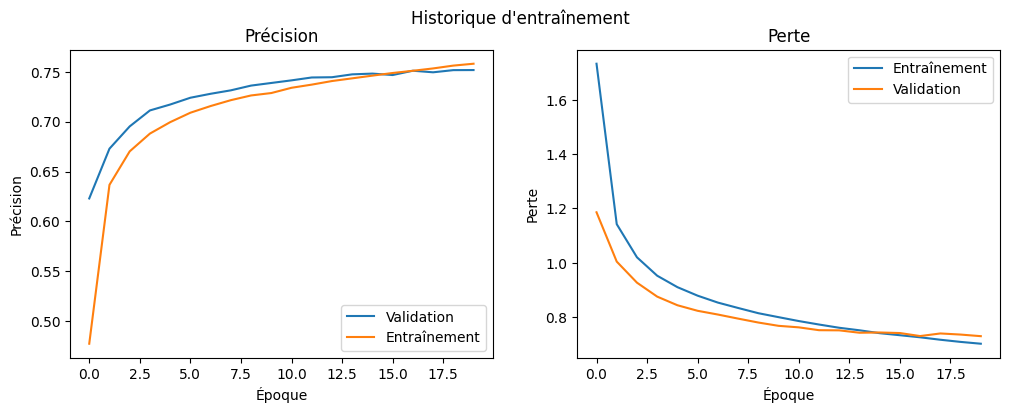

In [ ]:
config["callback_param"] = dict(patience=2,model_file="one_hot_model_2.h5")

callbacks = [MyCustomCallback(**config["callback_param"])]
config["batch_size"] = 256
model = build_one_hot_model(seq_len,mol_encoder_2.voc_len)
history = model.fit(X_train_tensor, y_train_tensor, epochs=20,validation_split=0.2,callbacks=callbacks,batch_size=config["batch_size"])
save_history(model,history,"history_2.csv")
plot_history(history)

Generate between 100 and 1000 molecules.

In [ ]:
def generate_molecules(n_molecules = 50,model = None,mol_encoder =None , seq_len = None,smiles_set = None):

    molecules_list = []
    for i in tqdm(range(n_molecules)):
        seed_start = random.choice(smiles_set)[:seq_len]
        molecules_list.append(make_prediction(seed_start,model,mol_encoder,seq_len))

    generated_df = pd.DataFrame({"gen_mol":molecules_list})
    file_name = f'generated_molecules_{model.name}.csv'
    generated_df.to_csv(file_name)
    return generated_df

In [ ]:
n_molecules= 200
seq_len = 20
smiles_set =full_df['smiles']
model_1 = load_model('one_hot_model_1.h5')
gen_df_1 = generate_molecules(n_molecules=n_molecules,model = model_1, mol_encoder= mol_encoder,seq_len = seq_len,smiles_set =smiles_set)
model_2 = load_model('one_hot_model_2.h5')
gen_df_2 = generate_molecules(n_molecules=n_molecules,model = model_2, mol_encoder= mol_encoder_2,seq_len = seq_len,smiles_set =smiles_set)

100%|██████████| 200/200 [03:41<00:00,  1.11s/it]


In [ ]:
from rdkit import rdBase
def get_valid_mols_list(gen_smiles):
    rdBase.DisableLog('rdApp.error')
    gen_mol_list = []
    for gen_smiles in gen_smiles:
        current_mol = MolFromSmiles(gen_smiles)
        if current_mol is not None:
            gen_mol_list.append(current_mol)

    rdBase.EnableLog('rdApp.error')
    return gen_mol_list

Gardons les molécules qui sont valides selon la fonction `get_valid_mols_list`

In [ ]:
gen_mol_sets = []
files_list = ['one_hot_model_1.h5','one_hot_model_2.h5']
for df,file_name in zip([gen_df_1,gen_df_2],files_list):
    gen_mol_list = get_valid_mols_list(df["gen_mol"])
    gen_mol_sets.append(gen_mol_list)
    n_gen_mol = len(gen_mol_list)
    n_mol = len(df)
    print(f'{n_gen_mol} molécules sur {n_mol} sont valides pour le modèle {file_name}')


85 molécules sur 200 sont valides pour le modèle one_hot_model_1.h5
112 molécules sur 200 sont valides pour le modèle one_hot_model_2.h5


Affichons les molécules générées par leur modèle respectif.

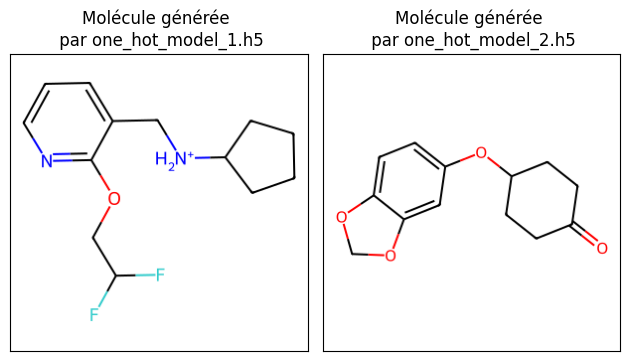

In [ ]:
fig = plt.figure()
fig.set_facecolor('white')
for i,mol_set in enumerate(gen_mol_sets):
    ax = fig.add_subplot(1,len(gen_mol_sets),i+1)
    mol = random.choice(mol_set)
    img = MolToImage(mol)
    ax.set_title(f'Molécule générée \n par {files_list[i]}')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)
plt.tight_layout()
plt.show()

create a list where molecules have between 10 and 50 atoms

In [ ]:
between_10_and_50 = lambda mol: ((mol.GetNumAtoms() >= 10) and (mol.GetNumAtoms() <= 50))

In [ ]:
qed_dfs = []
for mol_set,file_name in zip(gen_mol_sets,files_list):
    gen_mol_list_10_50 = list(filter(between_10_and_50, mol_set ))
    qed = lambda x : QED.qed(x)
    qed_list = list(map(qed,gen_mol_list_10_50))
    qed_df = pd.DataFrame({
        f"gen_mol_{file_name}":list(map(MolToSmiles,gen_mol_list_10_50)),
        "qed": qed_list
    })
    qed_dfs.append(qed_df)


In [ ]:

qed_dfs[0].head()

,gen_mol_one_hot_model_1.h5,qed
0,CC(C)NS(=O)(=O)c1ccc(C(=O)N2CCOCC2)cc1,0.893956
1,CC[NH2+]CC(=O)N1C=CN(C(=O)CCCC(=O)Nc2ccc(C(=O)...,0.524705
2,FC(F)COc1ncccc1C[NH2+]C1CCCC1,0.842623
3,COc1ccc(S(N)(=O)=O)cc1,0.725528
4,O=C(NCCc1cccc(O)c1)NC1CCCC1,0.764463


In [ ]:
qed_dfs[1].head()

,gen_mol_one_hot_model_2.h5,qed
0,CCc1cc(CNc2ccccc2Cc2ccccc2)on1,0.729596
1,CC1C=CN(/C(N)=[NH+]/C2CCCCC2)CC1,0.503059
2,O=C(Cc1ccc(F)cc1F)NC(=O)NCc1ccccc1,0.911698
3,C[C@@H]1CCN(c2ccc3c(c2)OCO3)C1=O,0.722396
4,C[C@@H](C(=O)NCCc1ccccc1)C(=O)Nc1ccc(C(=O)Nc2c...,0.375186
